In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pykalman import KalmanFilter
import statsmodels.api as sm
plt.style.use('seaborn-whitegrid')

C:\Users\redce\AppData\Local\Temp\ipykernel_22536\1006355162.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
df1 = pd.read_csv('../data/prices_round_4_day_1.csv', index_col='timestamp', delimiter=';')
df2 = pd.read_csv('../data/prices_round_4_day_2.csv', index_col='timestamp', delimiter=';')
df3 = pd.read_csv('../data/prices_round_4_day_3.csv', index_col='timestamp', delimiter=';')
df = pd.concat([df1,df2,df3], ignore_index=True).reset_index(drop=True)
df.head(10)

,day,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,1,DOLPHIN_SIGHTINGS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3047.0,0.0
1,1,PINA_COLADAS,15013.0,34.0,15012.0,54.0,NaN,NaN,15016.0,88.0,NaN,NaN,NaN,NaN,15014.5,0.0
2,1,DIP,6999.0,237.0,NaN,NaN,NaN,NaN,7001.0,237.0,NaN,NaN,NaN,NaN,7000.0,0.0
3,1,BAGUETTE,11999.0,90.0,NaN,NaN,NaN,NaN,12001.0,90.0,NaN,NaN,NaN,NaN,12000.0,0.0
4,1,PICNIC_BASKET,73358.0,12.0,73357.0,27.0,NaN,NaN,73372.0,12.0,73373.0,27.0,NaN,NaN,73365.0,0.0
5,1,BERRIES,3916.0,12.0,3915.0,44.0,NaN,NaN,3923.0,12.0,3924.0,44.0,NaN,NaN,3919.5,0.0
6,1,DIVING_GEAR,98903.0,10.0,98902.0,12.0,NaN,NaN,98905.0,10.0,98906.0,12.0,NaN,NaN,98904.0,0.0
7,1,BANANAS,4871.0,9.0,4870.0,23.0,NaN,NaN,4877.0,23.0,NaN,NaN,NaN,NaN,4874.0,0.0
8,1,COCONUTS,8003.0,200.0,NaN,NaN,NaN,NaN,8006.0,200.0,NaN,NaN,NaN,NaN,8004.5,0.0
9,1,PEARLS,9998.0,9.0,9995.0,23.0,NaN,NaN,10005.0,23.0,NaN,NaN,NaN,NaN,10001.5,0.0


In [4]:
df_pina_coladas = df.loc[df['product']=='PINA_COLADAS'][['mid_price']]
df_coconuts = df.loc[df['product']=='COCONUTS'][['mid_price']]

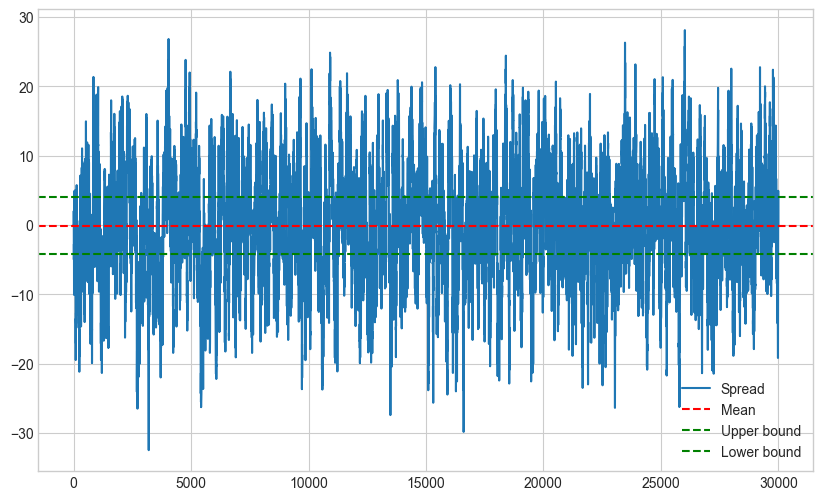

In [10]:
# Load data
x = np.array(df_coconuts['mid_price'])
y = np.array(df_pina_coladas['mid_price'])
n = len(x)

# Calculate Hurst exponent
def hurst_exponent(series):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

hurst = hurst_exponent(x)

# Initialize Kalman filter parameters
xhat = np.zeros(n)
P = np.zeros(n)
xhatminus = np.zeros(n)
Pminus = np.zeros(n)
K = np.zeros(n)

# Set initial values
xhat[0] = y[0]
P[0] = 1.0

# Define measurement and process noises
R = 0.01
Q = 0.00001

# Run Kalman filter
for k in range(1, n):
    # Time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1] + Q
    
    # Measurement update
    K[k] = Pminus[k] / (Pminus[k] + R)
    xhat[k] = xhatminus[k] + K[k] * (y[k] - xhatminus[k])
    P[k] = (1 - K[k]) * Pminus[k]

# Compute spread
spread = y - xhat

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(spread, label='Spread')
plt.axhline(np.mean(spread), color='r', linestyle='--', label='Mean')
plt.axhline(np.mean(spread) + hurst * np.std(spread), color='g', linestyle='--', label='Upper bound')
plt.axhline(np.mean(spread) - hurst * np.std(spread), color='g', linestyle='--', label='Lower bound')
plt.legend()
plt.show()

In [11]:
# Define trading signals
upper_bound = np.mean(spread) + hurst * np.std(spread)
lower_bound = np.mean(spread) - hurst * np.std(spread)

if spread[-1] > upper_bound:
    signal = -1  # short y, long x
elif spread[-1] < lower_bound:
    signal = 1  # long y, short x
else:
    signal = 0  # no position

print(f"Current spread: {spread[-1]}")
print(f"Upper bound: {upper_bound}")
print(f"Lower bound: {lower_bound}")
print(f"Trade signal: {signal}")

Current spread: -0.16618457328331715
Upper bound: 4.069303549218874
Lower bound: -4.256763479389389
Trade signal: 0


In [13]:
# Define trading signals
upper_bound = np.mean(spread) + hurst * np.std(spread)
lower_bound = np.mean(spread) - hurst * np.std(spread)
signals = np.zeros(n)

for i in range(1, n):
    if spread[i] > upper_bound:
        signals[i] = -1  # short y, long x
    elif spread[i] < lower_bound:
        signals[i] = 1  # long y, short x
    else:
        signals[i] = 0  # no position
        
for i in signals:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
-1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1